**Proposed Logistic Regression Workflow (without L1/L2 regularization)**
1. Import dependencies (kagglehub, sklearn, scipy, etc.)
2. Extract data and inspect for errors (read_csv, info(), describe(), etc.)
3. Pre-processing (dropping unnecessary columns, checking for NaN, split dataset into X and y, define categorical and numerical features, etc.)
4. Feature engineering (define custom features for various use-case such as ratios, products, etc.)
5. Apply log transform to numerical features (to transform skewed numerical features)
6. Use MinMaxScaler() and Chi-squared test to drop categorical variables that have weak correlation (p > 0.1 or 0.05)
7. Use Welch's t-test (ttest_ind) to drop numerical variables that have weak significance (p > 0.1 or 0.05)
8. Feature scaling with Z-score normalisation (use StandardScaler())
9. Optional EDA (seaborn's feature correlation heatmap and feature distribution historgrams)
10. Train-test split (define X_train, X_test, y_train, y_test with test_size=0.2 and stratify=y)
11. Hyperparameter tuning and model fitting (finding optimal weights with GridSearchCV, call LogisticRegression, etc.)
12. Evaluation and scoring (precision_recall_curve, accuracy_score, classification_report, confusion_matrix, etc.)

In [151]:
# 1. Import dependencies (kagglehub, sklearn, scipy, etc.)

# System utilities
import os

# Kaggle resources
import kagglehub

# Data wrangling/handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature engineering
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ttest_ind

# Scaling
from sklearn.preprocessing import StandardScaler

# Model training
from sklearn.linear_model import LogisticRegression

# Train/Test splitting
from sklearn.model_selection import train_test_split

# Hyperparameter tuning
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve

In [152]:
# 2. Extract data and inspect for errors (read_csv, info(), describe(), etc.)

path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")
print("Path to dataset files:", path)
print(os.listdir(path))

Path to dataset files: C:\Users\leonk\.cache\kagglehub\datasets\fedesoriano\stroke-prediction-dataset\versions\1
['healthcare-dataset-stroke-data.csv']


In [153]:
# 2. Extract data and inspect for errors (read_csv, info(), describe(), etc.)

df = pd.read_csv(os.path.join(path, 'healthcare-dataset-stroke-data.csv'))
display(df)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [154]:
# 2. Extract data and inspect for errors (read_csv, info(), describe(), etc.)

def check_dataframe(df, name="DataFrame", value_ranges=None):
    """
    Checks a DataFrame for NaNs, inf, mixed types, and unexpected dtypes.
    Optionally checks if numeric columns are within expected ranges, and
    shows offending values in [index, value] format.
    """
    print(f"\n🔍 Checking {name}...")
    issues_found = False

    # 1. NaN check
    nan_counts = df.isna().sum()
    if nan_counts.any():
        print("\n ⚠️ NaNs detected:")
        print(nan_counts[nan_counts > 0])
        issues_found = True

    # 2. Inf check
    inf_counts = df.isin([np.inf, -np.inf]).sum()
    if inf_counts.any():
        print("\n ⚠️ Infs detected:")
        print(inf_counts[inf_counts > 0])
        issues_found = True

    # 3. Mixed type check
    for col in df.columns:
        types_in_col = {type(v) for v in df[col] if pd.notna(v)}
        if len(types_in_col) > 1:
            print(f"\n ⚠️ Mixed types in '{col}': {types_in_col}")
            issues_found = True

    # 4. Dtype check
    for col in df.columns:
        if not (np.issubdtype(df[col].dtype, np.number) or df[col].dtype == bool):
            print(f"\n ⚠️ Non-numeric column detected: '{col}' ({df[col].dtype})")
            issues_found = True

    # 5. Range check (if provided)
    if value_ranges:
        for col, (min_val, max_val) in value_ranges.items():
            if col in df.columns:
                if np.issubdtype(df[col].dtype, np.number):
                    # Numeric range check
                    mask = (df[col] < min_val) | (df[col] > max_val)
                    if mask.any():
                        offending_list = [[idx, val] for idx, val in df.loc[mask, col].items()]
                        print(f"\n ⚠️ '{col}' has values outside [{min_val}, {max_val}]:")
                        print(offending_list[:50)
                        issues_found = True

                elif np.issubdtype(df[col].dtype, np.datetime64):
                    # Datetime range check
                    mask = (df[col] < pd.to_datetime(min_val)) | (df[col] > pd.to_datetime(max_val))
                    if mask.any():
                        offending_list = [[idx, val] for idx, val in df.loc[mask, col].items()]
                        print(f"\n ⚠️ '{col}' has datetimes outside [{min_val}, {max_val}]:")
                        print(offending_list)
                        issues_found = True

    if not issues_found:
        print("\n ✅ No issues found!")

# Age, BMI, and average glucose level were the numerical features chosen to go through a sanity check
expected_ranges = {
    'age': (18, 120),
    'bmi': (10, 80),
    'avg_glucose_level': (50, 300)
}
check_dataframe(df, value_ranges=expected_ranges)


🔍 Checking DataFrame...

 ⚠️ NaNs detected:
bmi    201
dtype: int64

 ⚠️ Non-numeric column detected: 'gender' (object)

 ⚠️ Non-numeric column detected: 'ever_married' (object)

 ⚠️ Non-numeric column detected: 'work_type' (object)

 ⚠️ Non-numeric column detected: 'Residence_type' (object)

 ⚠️ Non-numeric column detected: 'smoking_status' (object)

 ⚠️ 'age' has values outside [18, 120]:
[[162, 1.32], [245, 14.0], [249, 3.0], [251, 8.0], [253, 14.0], [282, 3.0], [284, 14.0], [288, 17.0], [290, 13.0], [291, 4.0], [292, 16.0], [306, 13.0], [321, 11.0], [327, 8.0], [335, 11.0], [363, 0.64], [369, 4.0], [376, 0.88], [378, 14.0], [380, 4.0], [383, 5.0], [384, 4.0], [395, 17.0], [400, 5.0], [401, 13.0], [410, 7.0], [414, 12.0], [416, 3.0], [421, 12.0], [425, 5.0], [437, 2.0], [445, 13.0], [451, 13.0], [455, 13.0], [459, 11.0], [460, 7.0], [461, 16.0], [480, 11.0], [483, 9.0], [496, 5.0], [497, 14.0], [498, 15.0], [519, 10.0], [525, 5.0], [535, 12.0], [538, 16.0], [546, 9.0], [550, 15.0],

In [155]:
# 2. Extract data and inspect for errors (read_csv, info(), describe(), etc.)

df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [156]:
# 2. Extract data and inspect for errors (read_csv, info(), describe(), etc.)

df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [157]:
# 3. Pre-processing (dropping unnecessary columns, checking for NaN, split dataset into X and y, define categorical and numerical features, etc.)

# Dropping BMI outliers, identified by checker function above
X = df.copy()
X = X.drop(X.index[2128])
X = X.drop(X.index[4209])
X = X.reset_index()

# Dropping unique identifier and target variable from dataset
X = X.drop('id', axis=1)
y = X['stroke']
X = X.drop('stroke', axis=1)

# Backfilling NaN values with mean
X['bmi'] = X['bmi'].fillna(X['bmi'].mean())

# Binary encoding for binary features
X['ever_married'] = X['ever_married'].map({'Yes': 1, 'No': 0})
X['Residence_type'] = X['Residence_type'].map({'Urban': 1, 'Rural': 0})

# One-hot encoding for multicategorical features
X = pd.get_dummies(X, columns=['gender', 'work_type', 'smoking_status'], drop_first=True)

# Only convert new dummy columns to int
dummy_cols = [col for col in X.columns if any(cat in col for cat in ['gender_', 'work_type_', 'smoking_status_'])]
X[dummy_cols] = X[dummy_cols].astype(int)

display(X)

,index,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_Male,gender_Other,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,67.0,0,1,1,1,228.69,36.600000,1,0,0,1,0,0,1,0,0
1,1,61.0,0,0,1,0,202.21,28.877379,0,0,0,0,1,0,0,1,0
2,2,80.0,0,1,1,0,105.92,32.500000,1,0,0,1,0,0,0,1,0
3,3,49.0,0,0,1,1,171.23,34.400000,0,0,0,1,0,0,0,0,1
4,4,79.0,1,0,1,0,174.12,24.000000,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5103,5105,80.0,1,0,1,1,83.75,28.877379,0,0,0,1,0,0,0,1,0
5104,5106,81.0,0,0,1,1,125.20,40.000000,0,0,0,0,1,0,0,1,0
5105,5107,35.0,0,0,1,0,82.99,30.600000,0,0,0,0,1,0,0,1,0
5106,5108,51.0,0,0,1,0,166.29,25.600000,1,0,0,1,0,0,1,0,0


In [158]:
# 4. Feature engineering (define custom features for various use-case such as ratios, products, etc.)

# BMI-to-age-ratio
X['bmi_age_ratio'] = X['bmi'] / X['age']

# Average glucose level * BMI
X['glucose_bmi_product'] = X['avg_glucose_level'] * X['bmi']

### Custom indicator for high risk patient

# Define thresholds for extremely low/high glucose levels
low_glucose_threshold = 75    # example low cutoff
high_glucose_threshold = 150  # example high cutoff

# Create a boolean mask for "extreme glucose"
extreme_glucose = (X['avg_glucose_level'] < low_glucose_threshold) | (X['avg_glucose_level'] > high_glucose_threshold)

# Create a boolean mask for old age (e.g., 65+)
old_age = X['age'] >= 50

# Combine all conditions into a single indicator (1 if all true, else 0)
X['high_risk_indicator'] = (
    (old_age) &
    (X['hypertension'] == 1) &
    (extreme_glucose)
).astype(int)

# Set categorical and numerical columns
categorical_cols = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
numerical_cols = [col for col in X.columns if col not in categorical_cols]

print(categorical_cols)
print(numerical_cols)

display(X)

['hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'gender_Male', 'gender_Other', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'high_risk_indicator']
['index', 'age', 'avg_glucose_level', 'bmi', 'bmi_age_ratio', 'glucose_bmi_product']


,index,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_Male,gender_Other,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,bmi_age_ratio,glucose_bmi_product,high_risk_indicator
0,0,67.0,0,1,1,1,228.69,36.600000,1,0,0,1,0,0,1,0,0,0.546269,8370.054000,0
1,1,61.0,0,0,1,0,202.21,28.877379,0,0,0,0,1,0,0,1,0,0.473400,5839.294859,0
2,2,80.0,0,1,1,0,105.92,32.500000,1,0,0,1,0,0,0,1,0,0.406250,3442.400000,0
3,3,49.0,0,0,1,1,171.23,34.400000,0,0,0,1,0,0,0,0,1,0.702041,5890.312000,0
4,4,79.0,1,0,1,0,174.12,24.000000,0,0,0,0,1,0,0,1,0,0.303797,4178.880000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5103,5105,80.0,1,0,1,1,83.75,28.877379,0,0,0,1,0,0,0,1,0,0.360967,2418.480513,0
5104,5106,81.0,0,0,1,1,125.20,40.000000,0,0,0,0,1,0,0,1,0,0.493827,5008.000000,0
5105,5107,35.0,0,0,1,0,82.99,30.600000,0,0,0,0,1,0,0,1,0,0.874286,2539.494000,0
5106,5108,51.0,0,0,1,0,166.29,25.600000,1,0,0,1,0,0,1,0,0,0.501961,4257.024000,0


In [159]:
# 5. Apply log transform to numerical features (to transform skewed numerical features)
# No need log transform in this case as numerical features look fairly linear

# X[numerical_cols] = X[numerical_cols].apply(lambda col: np.log1p(col.clip(lower=0)))

# display(X)

In [160]:
# 6. Use MinMaxScaler() and Chi-squared test to drop categorical variables that have weak correlation (p > 0.1 or 0.05)

X_minmax = MinMaxScaler().fit_transform(X[categorical_cols])
chi_scores, p_values = chi2(X_minmax, y)

feature_scores = pd.DataFrame({
    'Feature': X[categorical_cols].columns,
    'Chi2 Score': chi_scores,
    'p-value': p_values
}).sort_values('Chi2 Score', ascending=False)

print(feature_scores)

p_threshold = 0.05
selected_categorical = feature_scores[feature_scores['p-value'] <= p_threshold]['Feature'].tolist()
X = X[selected_categorical + numerical_cols]

print("\n Dropped categorical features:", set(categorical_cols) - set(selected_categorical))

display(X)

                           Feature  Chi2 Score       p-value
13             high_risk_indicator  107.042730  4.356739e-25
1                    heart_disease   87.927156  6.790989e-21
0                     hypertension   75.715437  3.276361e-18
9               work_type_children   31.074912  2.482595e-08
2                     ever_married   20.568567  5.753306e-06
10  smoking_status_formerly smoked   17.578712  2.756570e-05
8          work_type_Self-employed   16.557453  4.719813e-05
6           work_type_Never_worked    1.127392  2.883322e-01
3                   Residence_type    0.600615  4.383435e-01
12           smoking_status_smokes    0.342242  5.585379e-01
7                work_type_Private    0.308124  5.788338e-01
4                      gender_Male    0.249824  6.171990e-01
11     smoking_status_never smoked    0.054232  8.158566e-01
5                     gender_Other    0.051245  8.209107e-01

 Dropped categorical features: {'smoking_status_smokes', 'smoking_status_never smoke

,high_risk_indicator,heart_disease,hypertension,work_type_children,ever_married,smoking_status_formerly smoked,work_type_Self-employed,index,age,avg_glucose_level,bmi,bmi_age_ratio,glucose_bmi_product
0,0,1,0,0,1,1,0,0,67.0,228.69,36.600000,0.546269,8370.054000
1,0,0,0,0,1,0,1,1,61.0,202.21,28.877379,0.473400,5839.294859
2,0,1,0,0,1,0,0,2,80.0,105.92,32.500000,0.406250,3442.400000
3,0,0,0,0,1,0,0,3,49.0,171.23,34.400000,0.702041,5890.312000
4,1,0,1,0,1,0,1,4,79.0,174.12,24.000000,0.303797,4178.880000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5103,0,0,1,0,1,0,0,5105,80.0,83.75,28.877379,0.360967,2418.480513
5104,0,0,0,0,1,0,1,5106,81.0,125.20,40.000000,0.493827,5008.000000
5105,0,0,0,0,1,0,1,5107,35.0,82.99,30.600000,0.874286,2539.494000
5106,0,0,0,0,1,1,0,5108,51.0,166.29,25.600000,0.501961,4257.024000


In [161]:
# 7. Use Welch's t-test (ttest_ind) to drop numerical variables that have weak significance (p > 0.1 or 0.05)

t_test_results = []
for column in numerical_cols:
    group0 = X[column][y == 0]
    group1 = X[column][y == 1]
    stat, pval = ttest_ind(group0, group1, equal_var=False)
    t_test_results.append({'Feature': column, 't-stat': stat, 'p-value': pval})
    
t_test_df = pd.DataFrame(t_test_results).sort_values('p-value')
print(t_test_df)

p_threshold = 0.05
selected_numerical = t_test_df[t_test_df['p-value'] <= p_threshold]['Feature'].tolist()
X = X[selected_numerical + selected_categorical]

print("\n Dropped categorical features:", set(numerical_cols) - set(selected_numerical))

display(X)

               Feature      t-stat       p-value
0                index  123.748219  0.000000e+00
1                  age  -29.673414  2.332996e-95
4        bmi_age_ratio    9.337552  6.349995e-20
2    avg_glucose_level   -6.979420  2.444782e-11
5  glucose_bmi_product   -6.840261  5.562681e-11
3                  bmi   -3.648818  3.115535e-04

 Dropped categorical features: set()


,index,age,bmi_age_ratio,avg_glucose_level,glucose_bmi_product,bmi,high_risk_indicator,heart_disease,hypertension,work_type_children,ever_married,smoking_status_formerly smoked,work_type_Self-employed
0,0,67.0,0.546269,228.69,8370.054000,36.600000,0,1,0,0,1,1,0
1,1,61.0,0.473400,202.21,5839.294859,28.877379,0,0,0,0,1,0,1
2,2,80.0,0.406250,105.92,3442.400000,32.500000,0,1,0,0,1,0,0
3,3,49.0,0.702041,171.23,5890.312000,34.400000,0,0,0,0,1,0,0
4,4,79.0,0.303797,174.12,4178.880000,24.000000,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5103,5105,80.0,0.360967,83.75,2418.480513,28.877379,0,0,1,0,1,0,0
5104,5106,81.0,0.493827,125.20,5008.000000,40.000000,0,0,0,0,1,0,1
5105,5107,35.0,0.874286,82.99,2539.494000,30.600000,0,0,0,0,1,0,1
5106,5108,51.0,0.501961,166.29,4257.024000,25.600000,0,0,0,0,1,1,0


In [162]:
# 8. Feature scaling with Z-score normalisation (use StandardScaler())

scaler = StandardScaler()

X_scaled = X.copy()
X_scaled[selected_numerical] = scaler.fit_transform(X_scaled[selected_numerical])

display(X_scaled)

,index,age,bmi_age_ratio,avg_glucose_level,glucose_bmi_product,bmi,high_risk_indicator,heart_disease,hypertension,work_type_children,ever_married,smoking_status_formerly smoked,work_type_Self-employed
0,-1.731437,1.051056,-0.183897,2.705873,2.918060,1.011153e+00,0,1,0,0,1,1,0
1,-1.730760,0.785668,-0.195928,2.121109,1.510071,-4.651709e-16,0,0,0,0,1,0,1
2,-1.730082,1.626063,-0.207015,-0.005285,0.176557,4.743242e-01,0,1,0,0,1,0,0
3,-1.729404,0.254893,-0.158177,1.436971,1.538454,7.230987e-01,0,0,0,0,1,0,0
4,-1.728726,1.581831,-0.223931,1.500791,0.586298,-6.386147e-01,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5103,1.729052,1.626063,-0.214492,-0.494870,-0.393102,-4.651709e-16,0,0,1,0,1,0,0
5104,1.729730,1.670294,-0.192556,0.420480,1.047579,1.456329e+00,0,0,0,0,1,0,1
5105,1.730408,-0.364345,-0.129738,-0.511653,-0.325776,2.255496e-01,0,0,0,0,1,0,1
5106,1.731086,0.343355,-0.191213,1.327880,0.629773,-4.291203e-01,0,0,0,0,1,1,0


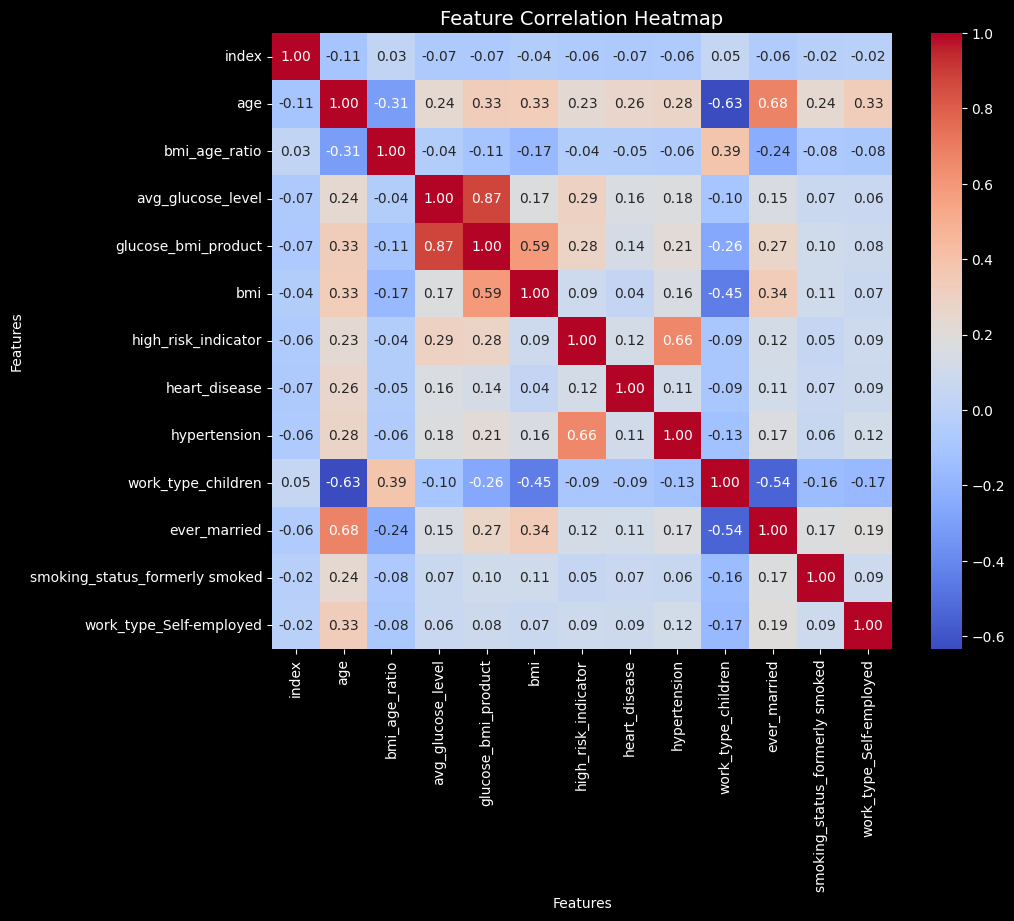

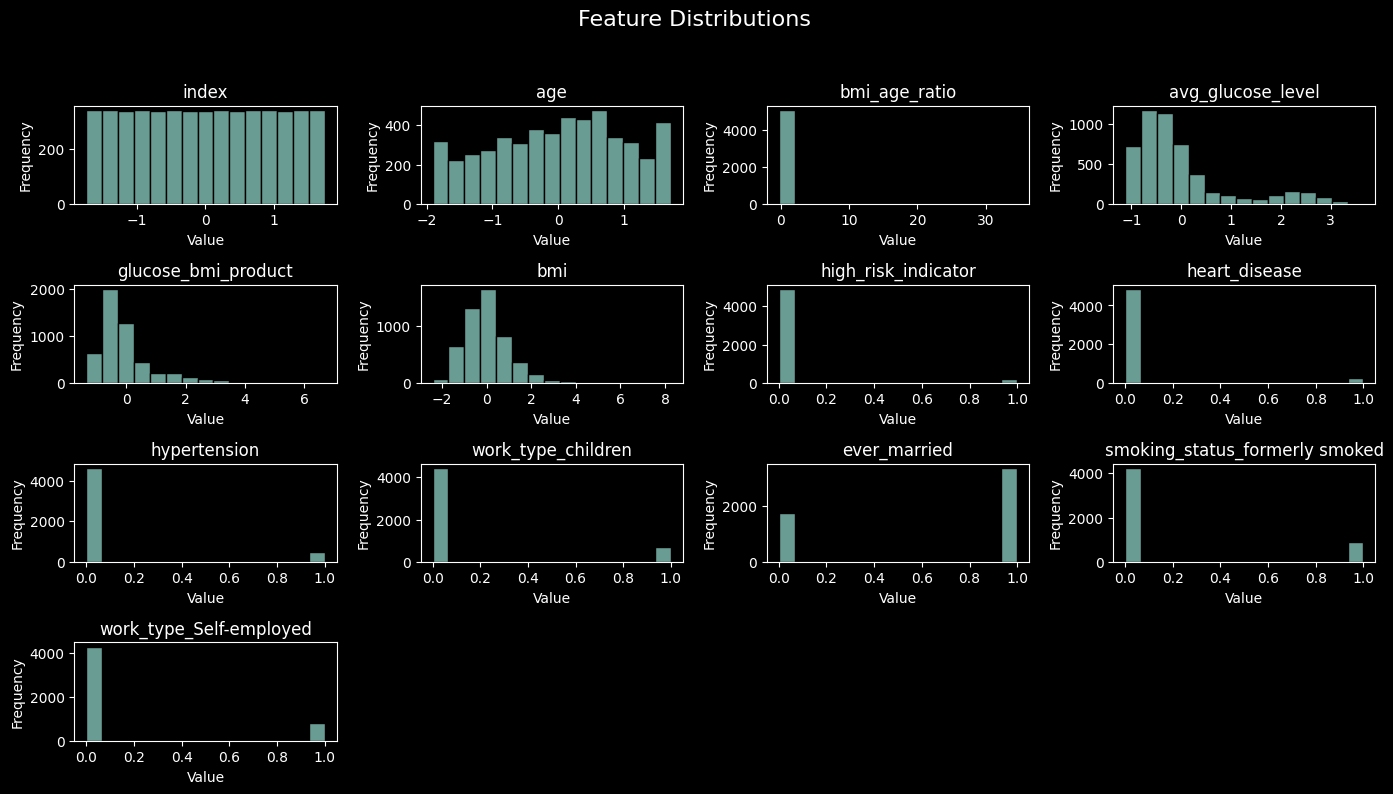

In [163]:
# 9. Optional EDA (seaborn's feature correlation heatmap and feature distribution historgrams)

# Correlation Heatmap for Features
plt.figure(figsize=(10, 8))
sns.heatmap(X_scaled.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.xlabel("Features")
plt.ylabel("Features")

plt.style.use("dark_background")
plt.show()

# Feature Distribution Histograms
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(14, 12))
fig.suptitle("Feature Distributions", fontsize=16, y=0.92)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each feature histogram
for i, col in enumerate(X_scaled.columns):
    sns.histplot(X_scaled[col], bins=15, edgecolor='black', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# Hide any unused subplots
for j in range(len(X_scaled.columns), len(axes)):
    fig.delaxes(axes[j])

plt.style.use("dark_background")
plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust layout to make room for suptitle
plt.show()

In [164]:
# 9. Optional EDA (seaborn's feature correlation heatmap and feature distribution historgrams)

# Multicollinearity between bmi and glucose_bmi_product
X_scaled = X_scaled.drop('bmi', axis=1)
display(X_scaled)

,index,age,bmi_age_ratio,avg_glucose_level,glucose_bmi_product,high_risk_indicator,heart_disease,hypertension,work_type_children,ever_married,smoking_status_formerly smoked,work_type_Self-employed
0,-1.731437,1.051056,-0.183897,2.705873,2.918060,0,1,0,0,1,1,0
1,-1.730760,0.785668,-0.195928,2.121109,1.510071,0,0,0,0,1,0,1
2,-1.730082,1.626063,-0.207015,-0.005285,0.176557,0,1,0,0,1,0,0
3,-1.729404,0.254893,-0.158177,1.436971,1.538454,0,0,0,0,1,0,0
4,-1.728726,1.581831,-0.223931,1.500791,0.586298,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5103,1.729052,1.626063,-0.214492,-0.494870,-0.393102,0,0,1,0,1,0,0
5104,1.729730,1.670294,-0.192556,0.420480,1.047579,0,0,0,0,1,0,1
5105,1.730408,-0.364345,-0.129738,-0.511653,-0.325776,0,0,0,0,1,0,1
5106,1.731086,0.343355,-0.191213,1.327880,0.629773,0,0,0,0,1,1,0


In [165]:
# 9. Optional EDA (seaborn's feature correlation heatmap and feature distribution historgrams)

# Check bmi_age_ratio outliers
bmi_age_ratio_list = list(X_scaled['bmi_age_ratio'])
print(sorted(bmi_age_ratio_list)[-50:])

[-0.25047441987568775, -0.2396425273441008, -0.23937596759642019, -0.2393443735964756, -0.2387106882261585, -0.2380490966572841, -0.23747084939976174, -0.23683581000087559, -0.23678877004540255, -0.23565595537999423, -0.2349542117819537, -0.23485096824331803, -0.23454653216785395, -0.234258608440396, -0.23422337149814074, -0.23348325966081002, -0.23333639457916544, -0.2332166017194188, -0.2331196535185048, -0.2330152477636744, -0.2326022140083013, -0.23249225047602665, -0.23231355973608034, -0.23197637807896423, -0.2318966146762056, -0.23180712402920808, -0.23154381501015772, -0.23108125544800606, -0.23080035425048614, -0.23051317729721135, -0.2302658962198066, -0.23013643039641005, -0.22998963963919952, -0.22944192404201347, -0.22942701701387055, -0.22939087656027543, -0.22939087656027543, -0.22936538871777615, -0.22930530112908407, -0.22927581715699294, -0.22921533721424187, -0.22915638840928199, -0.22915638840928199, -0.22900365741461312, -0.22888914211317465, -0.22883901757045746, 

In [166]:
# 10. Train-test split (define X_train, X_test, y_train, y_test with test_size=0.2 and stratify=y)

# 80% training, 20% testing with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Confirm split sizes and class balance
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

print("\nTraining target distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest target distribution:")
print(y_test.value_counts(normalize=True))

Training set size: 4086
Test set size: 1022

Training target distribution:
stroke
0    0.951297
1    0.048703
Name: proportion, dtype: float64

Test target distribution:
stroke
0    0.951076
1    0.048924
Name: proportion, dtype: float64


In [167]:
# 11. Hyperparameter tuning and model fitting (finding optimal weights with GridSearchCV, call LogisticRegression, etc.)

# Compute class weight from training set
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
balanced_weights = dict(zip(classes, weights))
print("Balanced class weights:", balanced_weights)

Balanced class weights: {np.int64(0): np.float64(0.5255981476717263), np.int64(1): np.float64(10.266331658291458)}


In [168]:
# 11. Hyperparameter tuning and model fitting (finding optimal weights with GridSearchCV, call LogisticRegression, etc.)

# Finding the best class weights (start with balanced weights + nearby variations)
weights_to_try = [
    {0: 1, 1: 5},
    {0: 1, 1: 6},
    {0: 1, 1: 7},
    {0: 1, 1: 8},
    {0: 1, 1: 9},
    balanced_weights,
    {0: 1, 1: 11},
    {0: 1, 1: 12},
    {0: 1, 1: 13},
    {0: 1, 1: 14},
    {0: 1, 1: 15},
    {0: 1, 1: 16},
    {0: 1, 1: 17},
    {0: 1, 1: 18},
    {0: 1, 1: 19},
    {0: 1, 1: 20}
]

log_reg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
param_grid = {'class_weight': weights_to_try}

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best class_weight:", grid_search.best_params_['class_weight'])
print("Best cross-val F1 score:", grid_search.best_score_)

# Use best model
model = grid_search.best_estimator_

Best class_weight: {0: 1, 1: 5}
Best cross-val F1 score: 0.8332946051984014


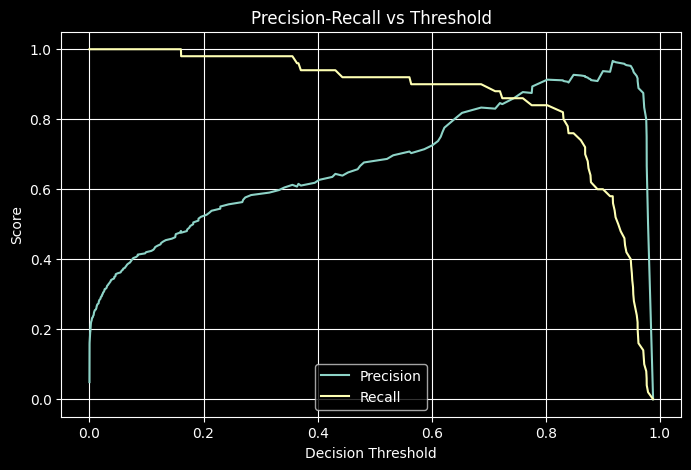

Test Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       972
           1       0.88      0.86      0.87        50

    accuracy                           0.99      1022
   macro avg       0.94      0.93      0.93      1022
weighted avg       0.99      0.99      0.99      1022



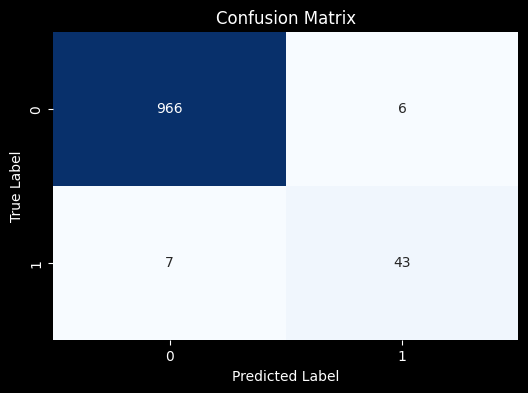

In [170]:
# 12. Evaluation and scoring (precision_recall_curve, accuracy_score, classification_report, confusion_matrix, etc.)

# Get probabilities for class 1
y_probs = model.predict_proba(X_test)[:, 1]

# Plot precision & recall vs threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Choose threshold
threshold = 0.75
y_pred = (y_probs >= threshold).astype(int)

# Now evaluate
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()